In [1]:
%matplotlib notebook
from CameraNetwork.transformation_matrices import euler_matrix, euler_from_matrix
from CameraNetwork.utils import object_direction
import cv2
import ephem
import fisheye
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import pandas as pd
import sklearn
from sklearn.base import BaseEstimator
from sklearn import linear_model

h:\amit\studies\cameranetwork\CameraNetwork\transformation_matrices.py:1899: UserWarning: failed to import module _transformations
  warnings.warn("failed to import module %s" % name)


In [2]:
def f(angles, calculated_directions, measured_directions):

    #
    # Calculate rotation matrix
    #
    M = euler_matrix(angles[0], angles[1], angles[2])[:3, :3]

    #
    # Rotate points
    #
    rotated_directions = np.dot(measured_directions, M.T)

    #
    # Calculate distance
    #
    ret = np.linalg.norm(calculated_directions - rotated_directions)

    return ret


def find_camera_orientation(calculated_directions, measured_directions):
    """
    Find the rotation of the camera based on the coordinates of a celestail object
    The input is two sets. The first is x,y image coordinates of the object (taken
    from several images). The second set is the azimuth/altitude coordinates of the
    celestial object (in Horizontal coordinate system).
    The output is the rotation matrix of the camera. The rotation matrix is converts
    between world coordinates to camera coordinates, where the world coordinates
    are centered in camera, z is in the zenith and the x-axis points to the North.
    The inner calibration of the camera is given as a function that converts
    between the image coordinates and the camera coordinates.

    Parameters:
    -----------
    calculated_directions -
        The reference direction of the celestial object. Given as an nx3 matrix of [x, y, z] on the
        unit hemisphere.

    measured_directions -
        The measured directions of the celestial objects. Given as an nx3 matrix of [x, y, z] on the
        unit hemisphere.

    Output:
    ------
        Euler angles for rotating the measured directions to match the calculated directions.

    """
    from scipy import optimize

    angles = optimize.fmin(f, x0=(0, 0, 0), args=(calculated_directions, measured_directions), xtol=1e-6, ftol=1e-6)

    return angles


class ExtrinsicModel(BaseEstimator):
    """Model for extrinsic rotation"""

    def __init__(self, ai=0, aj=0, ak=0):
        self.ai = ai
        self.aj = aj
        self.ak = ak
    
    def fit(self, X, y):
        self.ai, self.aj, self.ak = find_camera_orientation(y, X)
        return self

    def score(self, X, y):
        return f((self.ai, self.aj, self.ak), y, X)
    
    def predict(self, X):
        #
        # Calculate rotation matrix
        #
        M = euler_matrix(self.ai, self.aj, self.ak)[:3, :3]

        #
        # Rotate points
        #
        rotated_directions = np.dot(X, M.T)

        return rotated_directions

In [3]:
def handle_extrinsic(fe, today_positions_path):
    """Handle extrinsic calibration"""

    #
    # Calibratoin is done using the sun position.
    #
    positions_df = pd.read_csv(today_positions_path, index_col=0, parse_dates=True)
    positions_df = positions_df[positions_df['object']=='Sun']

    if positions_df.shape[0] < 100:
        raise Exception('No enough sun positions: {}'.format(
            positions_df.shape[0]))

    #
    # Convert sun measurments to directions.
    #
    measured_postions = \
        positions_df[['pos_x', 'pos_y']].as_matrix()
    measured_angles = fe.undistortDirections(
        measured_postions)

    measured_directions = np.array(
        (
            np.sin(measured_angles[1])*np.cos(measured_angles[0]),
            -np.sin(measured_angles[1])*np.sin(measured_angles[0]),
            np.cos(measured_angles[1])
        )
    ).T

    #
    # Calculated direction (using the ephem package.)
    #
    calculated_directions = []
    for date in positions_df.index:
        calculated_directions.append(object_direction(celestial_class=ephem.Sun, date=date))
    calculated_directions = np.array(calculated_directions)
    
    #
    # Estimate oreintation
    #
    angles = find_camera_orientation(calculated_directions, measured_directions)
    return positions_df, angles, calculated_directions, measured_directions

In [5]:
CAMERA = 103
today_positions_path = 'data/sun_positions_{}/2016_09_11.csv'.format(CAMERA)
fe = fisheye.load_model('data/sun_positions_{}/.calibration_data.dat'.format(CAMERA), calib_img_shape=(1200, 1600))
positions_df, angles, calculated_directions, measured_directions = handle_extrinsic(fe, today_positions_path)

In [13]:
positions_df.dropna()['pos_y']

2016-09-11 03:01:41.121332    598.103812
2016-09-11 03:04:40.846199    598.115518
2016-09-11 03:07:40.782855    598.178778
2016-09-11 03:10:40.744682    598.049734
2016-09-11 03:13:40.938626    597.963929
2016-09-11 03:16:40.876106    630.646599
2016-09-11 03:19:40.836215    653.035033
2016-09-11 03:22:40.773388    541.671962
2016-09-11 03:25:40.733665    519.783106
2016-09-11 03:28:40.953535    523.990164
2016-09-11 03:31:40.889557    519.509660
2016-09-11 03:37:40.788212    520.000000
2016-09-11 03:40:40.748667    524.000000
2016-09-11 03:43:40.943722    528.029851
2016-09-11 03:46:40.880351    536.000000
2016-09-11 03:49:40.841599    544.000000
2016-09-11 03:52:40.777286    551.985075
2016-09-11 03:55:40.737800    549.434343
2016-09-11 03:58:40.933302    555.827338
2016-09-11 04:01:40.870887    552.088235
2016-09-11 04:04:40.807860    564.888266
2016-09-11 04:09:24.343233    565.054673
2016-09-11 04:12:24.285075    572.169761
2016-09-11 04:15:24.219723    576.610295
2016-09-11 04:18

<IPython.core.display.Javascript object>


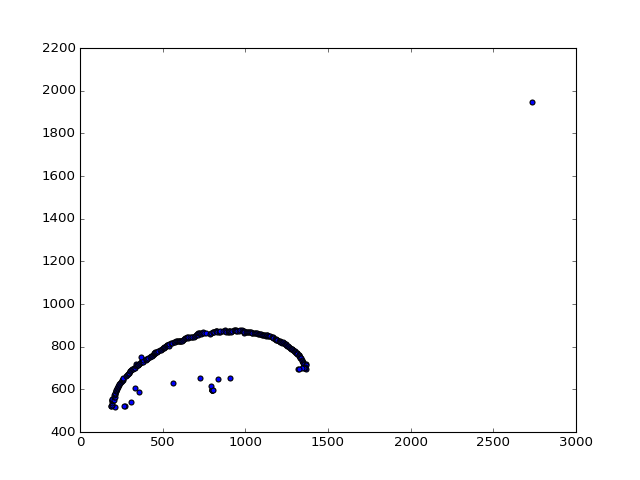

In [10]:
plt.figure()
plt.scatter(positions_df['pos_x'], positions_df['pos_y'])

<IPython.core.display.Javascript object>


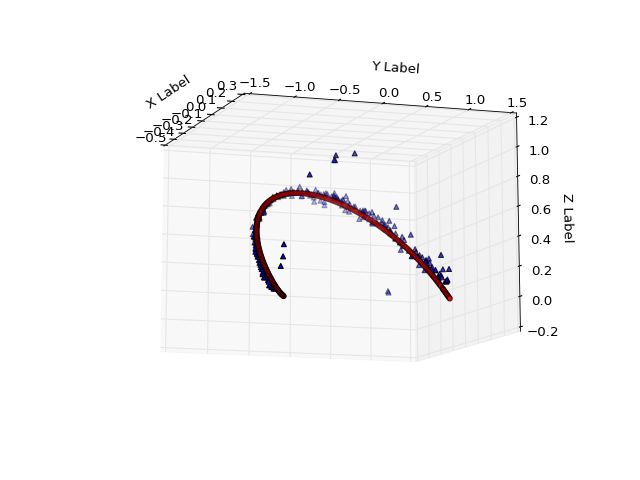

In [5]:
M = euler_matrix(*angles)[:3, :3]
rotated_directions = np.dot(measured_directions, M.T)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(calculated_directions[:, 0], calculated_directions[:, 1], calculated_directions[:, 2], c='r', marker='o')
ax.scatter(rotated_directions[:, 0], rotated_directions[:, 1], rotated_directions[:, 2], c='b', marker='^')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

Optimization terminated successfully.
         Current function value: 0.029530
         Iterations: 224
         Function evaluations: 400
Optimization terminated successfully.
         Current function value: 0.157268
         Iterations: 215
         Function evaluations: 385
Optimization terminated successfully.
         Current function value: 0.049352
         Iterations: 206
         Function evaluations: 373
Optimization terminated successfully.
         Current function value: 0.055340
         Iterations: 182
         Function evaluations: 341
Optimization terminated successfully.
         Current function value: 0.235125
         Iterations: 215
         Function evaluations: 389
Optimization terminated successfully.
         Current function value: 0.047754
         Iterations: 196
         Function evaluations: 358
Optimization terminated successfully.
         Current function value: 0.095970
         Iterations: 201
         Function evaluations: 366
Optimization termina

<IPython.core.display.Javascript object>


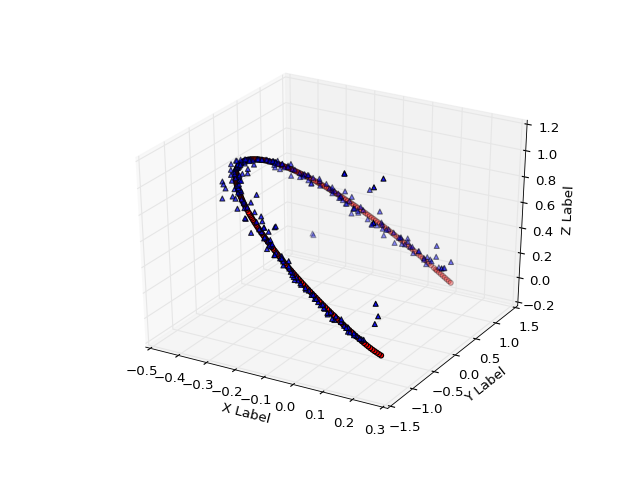

In [16]:
model_ransac = linear_model.RANSACRegressor(ExtrinsicModel())
model_ransac.fit(measured_directions, calculated_directions)

rotated_directions_ransac = model_ransac.predict(measured_directions)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(calculated_directions[:, 0], calculated_directions[:, 1], calculated_directions[:, 2], c='r', marker='o')
ax.scatter(rotated_directions_ransac[:, 0], rotated_directions_ransac[:, 1], rotated_directions_ransac[:, 2], c='b', marker='^')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

In [15]:
model_ransac.predict(np.eye(3)).T

array([[-0.99768042,  0.06806309,  0.00109452],
       [-0.06805712, -0.99766993,  0.00478987],
       [ 0.00141798,  0.00470427,  0.99998793]])